In [1]:
import sys
import torch 
import os
import random
import torch.nn as nn
import numpy as np
import pandas as pd 
from torch.utils.data import Dataset
from torchvision import transforms
from torch.optim import Adam, SGD, RMSprop
import time
from torch.autograd import Variable
import torch.functional as F
from tqdm import tqdm
from sklearn import metrics
import urllib
from sklearn.metrics import cohen_kappa_score, mean_squared_error, mean_absolute_error
import pickle
import cv2
import torch.nn.functional as F
from torchvision import models
import seaborn as sns
import random
import sys
import collections
from torch.utils.data import Dataset, WeightedRandomSampler, SubsetRandomSampler, DataLoader
from albumentations import (
    HorizontalFlip, VerticalFlip, CenterCrop, RandomRotate90, RandomCrop, 
    PadIfNeeded, Normalize, Flip, OneOf, Compose, Resize, Transpose, 
    IAAAdditiveGaussianNoise, GaussNoise, CLAHE, RandomBrightnessContrast, HueSaturationValue,
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose
)
from catalyst.contrib.schedulers import OneCycleLR, ReduceLROnPlateau, StepLR, MultiStepLR
from catalyst.dl.experiment import SupervisedExperiment
from catalyst.dl.runner import SupervisedRunner
from catalyst.dl.callbacks import EarlyStoppingCallback, AccuracyCallback, F1ScoreCallback, ConfusionMatrixCallback, MixupCallback
from catalyst.dl.core.state import RunnerState
from catalyst.dl.core import MetricCallback
from catalyst.dl.callbacks import CriterionCallback
from sklearn.model_selection  import train_test_split
from typing import List
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
%matplotlib inline
device = torch.device("cuda:0")

In [2]:
package_path = '/kaggle/aptos/EfficientNet-PyTorch/efficientnet_pytorch'
sys.path.append(package_path)
from efficientnet_pytorch import EfficientNet

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
num_classes = 1
seed_everything(1234)
lr          = 1e-3
IMG_SIZE    = 256
model = EfficientNet.from_pretrained('efficientnet-b7')
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, num_classes)
model.cuda()

Loaded pretrained weights for efficientnet-b7


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        64, 16, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        16, 64, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        64, 32, kernel_siz

In [5]:
train = pd.read_csv('/home/skolchen/kaggle/aptos/train.csv')
test = pd.read_csv('/home/skolchen/kaggle/aptos/test.csv')
sample_submission = pd.read_csv('/home/skolchen/kaggle/aptos/sample_submission.csv')
duplicated_images = pd.read_csv('/home/skolchen/kaggle/aptos/duplicated_info.csv')
duplicated_images['id_code'] = duplicated_images['path'].apply(lambda x: x.split('/')[-1].split('.')[0])
image_infos = pd.read_csv('/home/skolchen/kaggle/aptos/image_info.csv')
image_infos['id_code'] = image_infos['path'].apply(lambda x: x.split('/')[-1].split('.')[0])
train = train.loc[[x not in duplicated_images['id_code'].values for x in train['id_code'].values],:]
X = train['id_code'].values
X_train, X_test, y_train, y_test = train_test_split(X, train['diagnosis'].values, test_size=0.1, random_state=42, stratify=train['diagnosis'].values)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [6]:
def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol

        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if (check_shape == 0):  # image is too dark so that we crop out everything,
            return img  # return original image
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1, img2, img3], axis=-1)
        #         print(img.shape)
        return img
def process_regression(model, X, imagedir, regression_weights, transoformation=False): 
    #regression
    model.load_state_dict(torch.load(regression_weights)['model_state_dict'])
    model.eval()
    predicted_reg  = list()
    with torch.no_grad():
        for i, name in tqdm(enumerate(X), total=len(X)):
            image = cv2.imread(os.path.join(imagedir, name + '.png'))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = crop_image_from_gray(image)          
            if transoformation:
                augmented = transoformation(image=image)
                image = augmented['image']                
            #image = preprocess_image(name, imagedir)
            image = np.rollaxis(image, -1)    
            image = np.expand_dims(image, 0)
            image = torch.tensor(image, dtype=torch.float32).to(device)
            predicted_reg += [model(image)[0][0].cpu().numpy()]
    predicted_reg = np.array(predicted_reg)
    predicted_reg_raw = predicted_reg.copy()
    predicted_reg[predicted_reg<0] = 0
    predicted_reg[predicted_reg>4] = 4
    predicted_reg_clipped = list()
    for idx in range(len(predicted_reg)):
        if predicted_reg[idx]<0.5:
            predicted_reg_clipped.append(0)
        elif  predicted_reg[idx]>=0.5 and predicted_reg[idx]<1.5:
            predicted_reg_clipped.append(1)
        elif  predicted_reg[idx]>=1.5 and predicted_reg[idx]<2.5:
            predicted_reg_clipped.append(2)
        elif  predicted_reg[idx]>=2.5 and predicted_reg[idx]<3.5:
            predicted_reg_clipped.append(3)
        elif  predicted_reg[idx]>=3.5:
            predicted_reg_clipped.append(4)
    assert(len(predicted_reg_clipped)==len(predicted_reg))    
    return(predicted_reg_clipped, predicted_reg_raw)
def aug_val(resolution,p=1): 
    return Compose([Resize(resolution,resolution),Normalize()], p=p)

In [7]:
regression_weights = os.path.join('logs/efficient_net_b7_trainregression_smart_v1/','checkpoints/last.pth')

In [8]:
predicted_reg_clipped_val, predicted_reg_raw = process_regression(model, X_val,
                                                                  '/home/skolchen/kaggle/aptos/train/', 
                                                                  regression_weights, aug_val(IMG_SIZE))

100%|██████████| 606/606 [01:24<00:00,  7.16it/s]


In [9]:
validation_dt = pd.DataFrame({'id':X_val,
                              'regression_label':predicted_reg_clipped_val,
                              'regression_raw':predicted_reg_raw,
                              'true_label':y_val})
score_simple=cohen_kappa_score(validation_dt['true_label'].values, 
                               validation_dt['regression_label'].values, weights='quadratic')
print('Validation kappa simple {}'.format(score_simple))

Validation kappa simple 0.9336693420807345


In [10]:
predicted_reg_clipped_holdout, predicted_reg_raw = process_regression(model, X_test,
                                                                  '/home/skolchen/kaggle/aptos/train/', 
                                                                  regression_weights, aug_val(IMG_SIZE))

100%|██████████| 337/337 [00:48<00:00,  6.91it/s]


In [11]:
holdout_dt = pd.DataFrame({'id':X_test,
                              'regression_label':predicted_reg_clipped_holdout,
                              'regression_raw':predicted_reg_raw,
                              'true_label':y_test})
score_simple=cohen_kappa_score(holdout_dt['true_label'].values, 
                               holdout_dt['regression_label'].values, weights='quadratic')
print('Holdout kappa simple {}'.format(score_simple))

Holdout kappa simple 0.9349891019864041


In [12]:
submit = pd.read_csv('/home/skolchen/kaggle/aptos/sample_submission.csv')
submit.head()

,id_code,diagnosis
0,0005cfc8afb6,0
1,003f0afdcd15,0
2,006efc72b638,0
3,00836aaacf06,0
4,009245722fa4,0


In [13]:
predicted_reg_clipped_test, predicted_reg_raw = process_regression(model, submit['id_code'].values,
                                                                   '/home/skolchen/kaggle/aptos/test/', 
                                                                   regression_weights,
                                                                   aug_val(IMG_SIZE))

100%|██████████| 1928/1928 [02:28<00:00, 13.00it/s]


In [14]:
public_submission_1 = pd.read_csv('/home/skolchen/kaggle/aptos/APTOS-2019-Blindness-Detection/submission_public_kernel.csv')
public_submission_2 = pd.read_csv('/home/skolchen/kaggle/aptos/APTOS-2019-Blindness-Detection/submission_eye.csv')
public_submission_3 = pd.read_csv('/home/skolchen/kaggle/aptos/APTOS-2019-Blindness-Detection/submission_pytorch.csv')
public_submission_4 = pd.read_csv('/home/skolchen/kaggle/aptos/APTOS-2019-Blindness-Detection/submission_keras.csv')
submit['predicted_level']= predicted_reg_clipped_test
submit['regression_raw']= predicted_reg_raw
submit['diagnosis_public_kernel_1']= public_submission_1['diagnosis']
submit['diagnosis_public_kernel_2']= public_submission_2['diagnosis']
submit['diagnosis_public_kernel_3']= public_submission_3['diagnosis']
submit['diagnosis_public_kernel_4']= public_submission_4['diagnosis']

In [15]:
score_simple=cohen_kappa_score(submit['diagnosis_public_kernel_1'].values, 
                               submit['predicted_level'].values, weights='quadratic')
print('kappa with public submission {}'.format(score_simple))

kappa with public submission 0.8757006016433402


In [16]:
submit.groupby(['diagnosis_public_kernel_1', 'predicted_level']).size().unstack()

predicted_level,0,1,2,3,4
diagnosis_public_kernel_1,,,,,
0,292.0,28.0,1.0,NaN,NaN
1,27.0,89.0,22.0,NaN,NaN
2,NaN,99.0,912.0,38.0,1.0
3,NaN,1.0,190.0,148.0,34.0
4,NaN,NaN,1.0,14.0,31.0


(array([ 319.,    0.,  217.,    0.,    0., 1126.,    0.,  200.,    0.,
          66.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

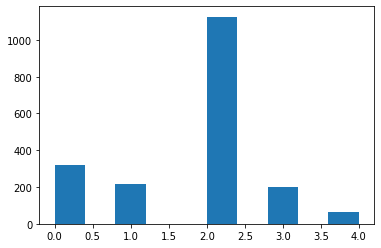

In [17]:
plt.hist(submit['predicted_level'].values)

(array([318.,  31., 139.,  72.,  24.,  17.,   1.,   2.,   1.,   1.]),
 array([-0.07064784,  0.6862839 ,  1.4432156 ,  2.2001472 ,  2.957079  ,
         3.7140107 ,  4.4709425 ,  5.2278743 ,  5.9848056 ,  6.7417374 ,
         7.498669  ], dtype=float32),
 <a list of 10 Patch objects>)

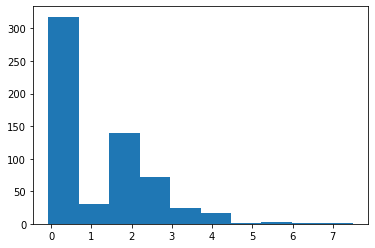

In [18]:
plt.hist(validation_dt['regression_raw'].values)

In [19]:
from pytorch_toolbelt.inference import tta

In [20]:
tta_model = tta.TTAWrapper(model, tta.d4_image2label)
def process_regression_tta(model, X, imagedir, regression_weights, transoformation=False): 
    #regression
    predicted_reg  = list()
    with torch.no_grad():
        for i, name in tqdm(enumerate(X), total=len(X)):
            image = cv2.imread(os.path.join(imagedir, name + '.png'))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = crop_image_from_gray(image)          
            if transoformation:
                augmented = transoformation(image=image)
                image = augmented['image']                
            #image = preprocess_image(name, imagedir)
            image = np.rollaxis(image, -1)    
            image = np.expand_dims(image, 0)
            image = torch.tensor(image, dtype=torch.float32).to(device)
            predicted_reg += [model(image)[0][0].cpu().numpy()]
    predicted_reg = np.array(predicted_reg)
    predicted_reg_raw = predicted_reg.copy()
    predicted_reg[predicted_reg<0] = 0
    predicted_reg[predicted_reg>4] = 4
    predicted_reg_clipped = list()
    for idx in range(len(predicted_reg)):
        if predicted_reg[idx]<0.5:
            predicted_reg_clipped.append(0)
        elif  predicted_reg[idx]>=0.5 and predicted_reg[idx]<1.5:
            predicted_reg_clipped.append(1)
        elif  predicted_reg[idx]>=1.5 and predicted_reg[idx]<2.5:
            predicted_reg_clipped.append(2)
        elif  predicted_reg[idx]>=2.5 and predicted_reg[idx]<3.5:
            predicted_reg_clipped.append(3)
        elif  predicted_reg[idx]>=3.5:
            predicted_reg_clipped.append(4)
    assert(len(predicted_reg_clipped)==len(predicted_reg))    
    return(predicted_reg_clipped, predicted_reg_raw)

In [ ]:
predicted_reg_clipped_val, predicted_reg_raw = process_regression_tta(tta_model, X_val,
                                                                  '/home/skolchen/kaggle/aptos/train/', 
                                                                  regression_weights, aug_val(IMG_SIZE))
validation_dt = pd.DataFrame({'id':X_val,
                              'regression_label':predicted_reg_clipped_val,
                              'regression_raw':predicted_reg_raw,
                              'true_label':y_val})
score_simple=cohen_kappa_score(validation_dt['true_label'].values, 
                               validation_dt['regression_label'].values, weights='quadratic')
print('Validation kappa simple {}'.format(score_simple))

In [22]:
predicted_reg_clipped_holdout, predicted_reg_raw = process_regression_tta(tta_model, X_test,
                                                                  '/home/skolchen/kaggle/aptos/train/', 
                                                                  regression_weights, aug_val(IMG_SIZE))
holdout_dt = pd.DataFrame({'id':X_test,
                              'regression_label':predicted_reg_clipped_holdout,
                              'regression_raw':predicted_reg_raw,
                              'true_label':y_test})
score_simple=cohen_kappa_score(holdout_dt['true_label'].values, 
                               holdout_dt['regression_label'].values, weights='quadratic')
print('Holdout kappa simple {}'.format(score_simple))

100%|██████████| 337/337 [02:11<00:00,  2.57it/s]

Holdout kappa simple 0.9371005508862822


In [23]:
predicted_reg_clipped_test, predicted_reg_raw = process_regression_tta(tta_model, submit['id_code'].values,
                                                                   '/home/skolchen/kaggle/aptos/test/', 
                                                                   regression_weights,
                                                                   aug_val(IMG_SIZE))

100%|██████████| 1928/1928 [10:14<00:00,  3.14it/s]


In [24]:
public_submission_1 = pd.read_csv('/home/skolchen/kaggle/aptos/APTOS-2019-Blindness-Detection/submission_public_kernel.csv')
public_submission_2 = pd.read_csv('/home/skolchen/kaggle/aptos/APTOS-2019-Blindness-Detection/submission_eye.csv')
public_submission_3 = pd.read_csv('/home/skolchen/kaggle/aptos/APTOS-2019-Blindness-Detection/submission_pytorch.csv')
public_submission_4 = pd.read_csv('/home/skolchen/kaggle/aptos/APTOS-2019-Blindness-Detection/submission_keras.csv')
submit['predicted_level']= predicted_reg_clipped_test
submit['regression_raw']= predicted_reg_raw
submit['diagnosis_public_kernel_1']= public_submission_1['diagnosis']
submit['diagnosis_public_kernel_2']= public_submission_2['diagnosis']
submit['diagnosis_public_kernel_3']= public_submission_3['diagnosis']
submit['diagnosis_public_kernel_4']= public_submission_4['diagnosis']
score_simple=cohen_kappa_score(submit['diagnosis_public_kernel_1'].values, 
                               submit['predicted_level'].values, weights='quadratic')
print('kappa with public submission {}'.format(score_simple))

kappa with public submission 0.883304580882939


In [27]:
submit.groupby(['diagnosis_public_kernel_1', 'predicted_level']).size().unstack()

predicted_level,0,1,2,3,4
diagnosis_public_kernel_1,,,,,
0,293.0,28.0,NaN,NaN,NaN
1,29.0,84.0,25.0,NaN,NaN
2,NaN,90.0,923.0,36.0,1.0
3,NaN,2.0,177.0,161.0,33.0
4,NaN,NaN,NaN,12.0,34.0


(array([ 322.,    0.,  204.,    0.,    0., 1125.,    0.,  209.,    0.,
          68.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

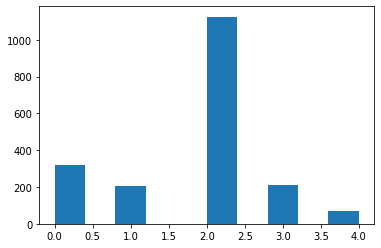

In [28]:
plt.hist(submit['predicted_level'].values)

7448 Try to find optimal thresholds for classes?

In [35]:
from functools import partial
import scipy as sp
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        print(-loss_partial(self.coef_['x']))

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p
    
    def coefficients(self):
        return self.coef_['x']

In [31]:
validation_dt.head()

,id,regression_label,regression_raw,true_label
0,2c827005b8f8,0,-0.003694,0
1,453d553b0a94,3,3.340679,2
2,0cd31078cd08,0,-0.015658,0
3,6966abf40b8c,0,0.000410,0
4,acf976efd7ce,0,0.007411,0


In [44]:
opt = OptimizedRounder()
opt.fit(X=validation_dt['regression_raw'].values,
        y=validation_dt['true_label'].values)

0.9437964031129848


In [46]:
opt_val_preds = opt.predict(validation_dt['regression_raw'].values,coef=opt.coefficients())
validation_dt['opt_preds'] = opt_val_preds
score_optim = cohen_kappa_score(validation_dt['true_label'].values, 
                               validation_dt['opt_preds'].values, weights='quadratic')
print('validation kappa optim {}'.format(score_optim))

validation kappa optim 0.9437964031129848


In [48]:
opt_holdout_preds = opt.predict(holdout_dt['regression_raw'].values,coef=opt.coefficients())
holdout_dt['opt_preds'] = opt_holdout_preds
score_optim = cohen_kappa_score(holdout_dt['true_label'].values, 
                               holdout_dt['opt_preds'].values, weights='quadratic')
print('holdout kappa optim {}'.format(score_optim))

holdout kappa optim 0.9320273988075548


In [50]:
opt_test_preds = opt.predict(submit['regression_raw'].values,coef=opt.coefficients())
submit['opt_preds']= opt_test_preds
score_optim =cohen_kappa_score(submit['diagnosis_public_kernel_1'].values, 
                               submit['opt_preds'].values, weights='quadratic')
print('kappa with public submission {}'.format(score_optim))

kappa with public submission 0.8777285148467636


In [51]:
submit.groupby(['diagnosis_public_kernel_1', 'opt_preds']).size().unstack()

opt_preds,0.0,1.0,2.0,3.0,4.0
diagnosis_public_kernel_1,,,,,
0,300.0,21.0,NaN,NaN,NaN
1,31.0,96.0,11.0,NaN,NaN
2,NaN,155.0,762.0,132.0,1.0
3,NaN,3.0,85.0,226.0,59.0
4,NaN,NaN,NaN,6.0,40.0


(array([331.,   0., 275.,   0.,   0., 858.,   0., 364.,   0., 100.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ],
       dtype=float32),
 <a list of 10 Patch objects>)

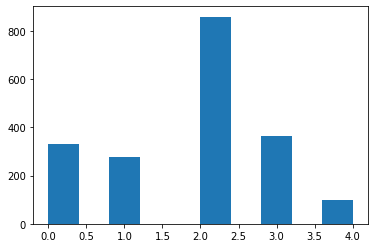

In [52]:
plt.hist(submit['opt_preds'].values)

In [53]:
opt.coefficients()

array([0.56391197, 1.62618105, 2.2919962 , 3.14798437])